In [2]:
#Extracts the contents of a zip file containing the dataset to a specified directory
import zipfile
import os
import shutil
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model


zip_path = '/content/num+plate.zip'
extract_to = 'dataset'


os.makedirs(extract_to, exist_ok=True)


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Extracted {zip_path} to {extract_to}/")

Extracted /content/num+plate.zip to dataset/


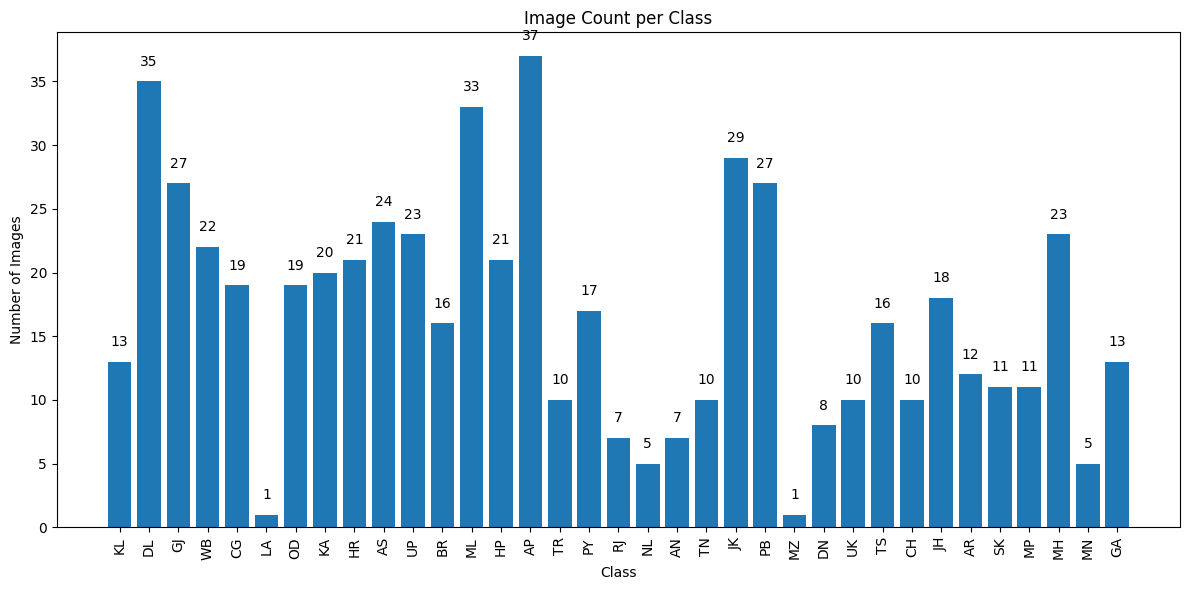

In [3]:
import os
import matplotlib.pyplot as plt

data_dir = os.path.join(extract_to, 'num plate')
class_counts = {}

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
        class_counts[class_name] = count

plt.figure(figsize=(12, 6))
bars = plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Image Count per Class')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, str(height), ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [4]:
#Creates a directory for augmented data and sets up an image data generator
aug = "aug_data"
os.makedirs(aug, exist_ok=True)

datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# performs data augmentation by resizing images, applying random transformations like rotation, zoom, and flips,
num_plate_folder = os.path.join(extract_to, "num plate")

for class_folder in os.listdir(num_plate_folder):
    class_path = os.path.join(num_plate_folder, class_folder)
    aug_class_path = os.path.join(aug, class_folder)
    os.makedirs(aug_class_path, exist_ok=True)

    if os.path.isdir(class_path):
        images = os.listdir(class_path)


        for img_name in images:
            try:
                shutil.copy(os.path.join(class_path, img_name), os.path.join(aug_class_path, img_name))
            except:
                continue


        aug_count = 0
        img_cycle = iter(images)

        while aug_count < 1000:
            try:
                img_name = next(img_cycle)
            except StopIteration:
                img_cycle = iter(images)
                img_name = next(img_cycle)

            try:
                img_path = os.path.join(class_path, img_name)
                img = Image.open(img_path).convert("RGB").resize((256, 256))
                img_array = np.expand_dims(np.array(img), 0)
                aug_iter = datagen.flow(img_array, batch_size=1)
                aug_img = next(aug_iter)[0].astype(np.uint8)
                aug_pil = Image.fromarray(aug_img)
                aug_pil.save(os.path.join(aug_class_path, f"{img_name.split('.')[0]}_extra{aug_count}.jpg"))
                aug_count += 1
            except:
                continue

In [6]:
#splits the augmented image data into training and testing sets, creating directories for each class and copying the corresponding images into the respective train and test directories.
train_dir = "processed/train"
test_dir = "processed/test"
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for class_folder in os.listdir(aug):
    class_path = os.path.join(aug, class_folder)

    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        if len(images) == 0:
            print(f"No images found for class {class_folder}.")
            continue

        train_imgs, test_imgs = train_test_split(images, test_size=0.05, random_state=42)

        os.makedirs(os.path.join(train_dir, class_folder), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_folder), exist_ok=True)

        for img in train_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_folder, img))
        for img in test_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_folder, img))


In [7]:
#defines a function to preprocess images by converting them to grayscale, resizing them to 128x128 pixels,
def preprocess_and_save(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for class_folder in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_folder)
        save_path = os.path.join(output_dir, class_folder)
        os.makedirs(save_path, exist_ok=True)
        for img_file in os.listdir(class_path):
            try:
                img = Image.open(os.path.join(class_path, img_file)).convert("L")
                img = img.resize((128, 128))
                img.save(os.path.join(save_path, img_file))
            except:
                pass

preprocess_and_save(train_dir, "final/train")
preprocess_and_save(test_dir, "final/test")


if not os.listdir(train_dir):
    print("train_dir is empty")
else:
    sample_class = os.listdir(train_dir)[0]
    sample_img_name = os.listdir(os.path.join(train_dir, sample_class))[0]

    original_img = Image.open(os.path.join(train_dir, sample_class, sample_img_name))
    processed_img = Image.open(os.path.join("final/train", sample_class, sample_img_name))

In [ ]:
sample_class = os.listdir(train_dir)[0]
sample_img_name = os.listdir(os.path.join(train_dir, sample_class))[0]

original_img = Image.open(os.path.join(train_dir, sample_class, sample_img_name))
processed_img = Image.open(os.path.join("final/train", sample_class, sample_img_name))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(original_img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grayscale Resized")
plt.imshow(processed_img, cmap='gray')
plt.axis("off")

plt.tight_layout()
plt.show()


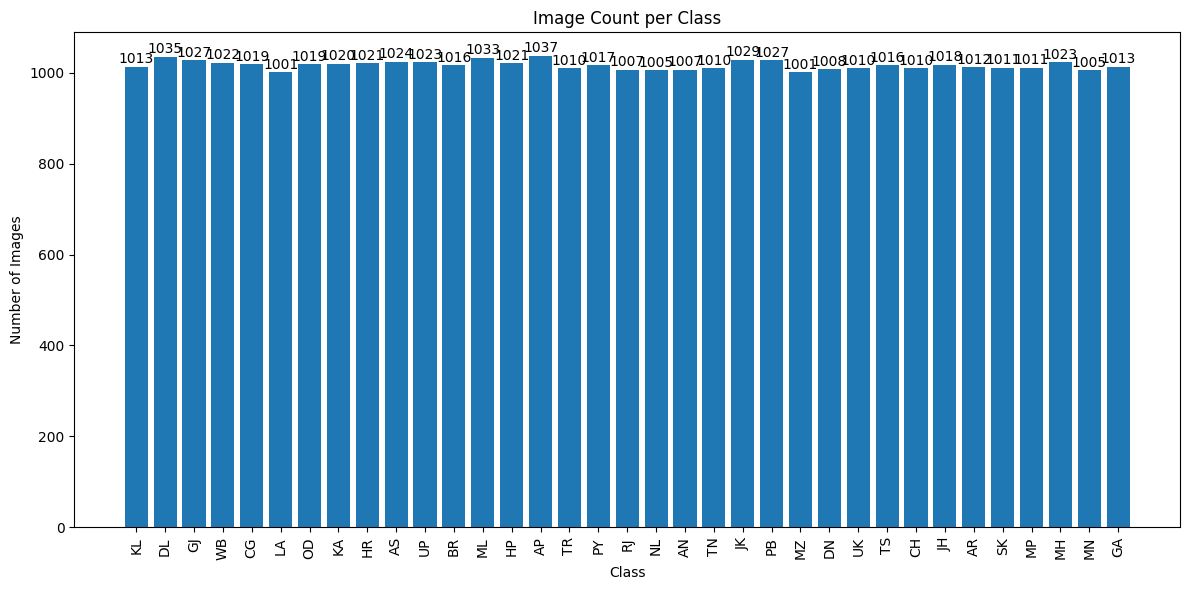

In [9]:
import os
import matplotlib.pyplot as plt

data_dir = os.path.join(extract_to, '/content/aug_data')
class_counts = {}

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
        class_counts[class_name] = count

plt.figure(figsize=(12, 6))
bars = plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Image Count per Class')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, str(height), ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [10]:
train_path = 'final/train'
test_path = 'final/test'


In [11]:
final_path = "final"

for split in ["train", "test"]:
    split_path = os.path.join(final_path, split)
    total = 0
    print(f"\nIn '{split}' folder:")
    for class_folder in os.listdir(split_path):
        class_path = os.path.join(split_path, class_folder)
        if os.path.isdir(class_path):
            count = len(os.listdir(class_path))
            total += count
            print(f"  {class_folder}: {count} images")
    print(f"Total images in '{split}': {total}")



In 'train' folder:
  KL: 962 images
  DL: 983 images
  GJ: 975 images
  WB: 970 images
  CG: 968 images
  LA: 950 images
  OD: 968 images
  KA: 969 images
  HR: 969 images
  AS: 972 images
  UP: 971 images
  BR: 965 images
  ML: 981 images
  HP: 969 images
  AP: 985 images
  TR: 959 images
  PY: 966 images
  RJ: 956 images
  NL: 954 images
  AN: 956 images
  TN: 959 images
  JK: 977 images
  PB: 975 images
  MZ: 950 images
  DN: 957 images
  UK: 959 images
  TS: 965 images
  CH: 959 images
  JH: 967 images
  AR: 961 images
  SK: 960 images
  MP: 960 images
  MH: 971 images
  MN: 954 images
  GA: 962 images
Total images in 'train': 33784

In 'test' folder:
  KL: 51 images
  DL: 52 images
  GJ: 52 images
  WB: 52 images
  CG: 51 images
  LA: 51 images
  OD: 51 images
  KA: 51 images
  HR: 52 images
  AS: 52 images
  UP: 52 images
  BR: 51 images
  ML: 52 images
  HP: 52 images
  AP: 52 images
  TR: 51 images
  PY: 51 images
  RJ: 51 images
  NL: 51 images
  AN: 51 images
  TN: 51 images

In [12]:
img_size = (128, 128)
batch_size = 35

In [13]:
#normalize pixel values. It then loads the images , resizing them, converting them to grayscale
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical'
)

num_classes = len(train_data.class_indices)

Found 33784 images belonging to 35 classes.
Found 1797 images belonging to 35 classes.


In [14]:
model = Sequential([  # Initializing a sequential model
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),  # 32 filters and 3x3 kernels, activation is relu
    MaxPooling2D((2, 2)),  # reducing spatial dimension, while saving the imp info

    Conv2D(64, (3, 3), activation='relu'),  # Second convolutional layer with 64 filters and 3x3 kernel
    MaxPooling2D((2, 2)), # reducing spatial dimension, while saving the imp info

    Conv2D(128, (3, 3), activation='relu'),  # Third convolutional layer with 128 filters and 3x3 kernel
    MaxPooling2D((2, 2)),  # reducing spatial dimension, while saving the imp info

    Flatten(),  # 2D to 1D
    Dense(128, activation='relu'),  #defines 128 neurons receiving input from the flattened vector while each has its own set of weights
    Dropout(0.5),  # it randomly sets 50% of the input to zero to prevent overfitting
    Dense(num_classes, activation='softmax')  # multi-class classification
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
    train_data,
    epochs=24,
    validation_data=test_data,
    callbacks=[checkpoint, early_stop]
)

model.load_weights("best_model.h5")
loss, accuracy = model.evaluate(test_data)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

model.save("final_model.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/24


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


965/966 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1121 - loss: 3.2872

966/966 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.1123 - loss: 3.2866 - val_accuracy: 0.4285 - val_loss: 2.2439
Epoch 2/24
966/966 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3333 - loss: 2.3259

966/966 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.3333 - loss: 2.3257 - val_accuracy: 0.6327 - val_loss: 1.4464
Epoch 3/24
965/966 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4646 - loss: 1.7916

966/966 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.4646 - loss: 1.7915 - val_accuracy: 0.6928 - val_loss: 1.1940
Epoch 4/24
965/966 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5473 - loss: 1.4821

966/966 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.5473 - loss: 1.4820 - val_accuracy: 0.7596 - val_loss: 0.9314
Epoch 5/24
964/966 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6039 - loss: 1.2628

966/966 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.6039 - loss: 1.2628 - val_accuracy: 0.8063 - val_loss: 0.6946
Epoch 6/24
963/966 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6492 - loss: 1.1000

966/966 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.6492 - loss: 1.1001 - val_accuracy: 0.8308 - val_loss: 0.6231
Epoch 7/24
965/966 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6750 - loss: 0.9890

966/966 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.6750 - loss: 0.9890 - val_accuracy: 0.8425 - val_loss: 0.5691
Epoch 8/24
965/966 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7073 - loss: 0.8844

966/966 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.7073 - loss: 0.8845 - val_accuracy: 0.8687 - val_loss: 0.4892
Epoch 9/24
966/966 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.7312 - loss: 0.8033 - val_accuracy: 0.8681 - val_loss: 0.4770
Epoch 10/24
966/966 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.7461 - loss: 0.7482 - val_accuracy: 0.8681 - val_loss: 0.4465
Epoch 11/24
965/966 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7711 - loss: 0.6819

966/966 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.7710 - loss: 0.6819 - val_accuracy: 0.8854 - val_loss: 0.3908
Epoch 12/24
964/966 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7775 - loss: 0.6580

966/966 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.7775 - loss: 0.6580 - val_accuracy: 0.8926 - val_loss: 0.3676
Epoch 13/24
966/966 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.7903 - loss: 0.6149 - val_accuracy: 0.8909 - val_loss: 0.3497
Epoch 14/24
966/966 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.8007 - loss: 0.5887 - val_accuracy: 0.8876 - val_loss: 0.3624
Epoch 15/24
965/966 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8094 - loss: 0.5520

966/966 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.8094 - loss: 0.5520 - val_accuracy: 0.8982 - val_loss: 0.3542
Epoch 16/24
966/966 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.8131 - loss: 0.5485 - val_accuracy: 0.8826 - val_loss: 0.4154
Epoch 17/24
966/966 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8269 - loss: 0.4972

966/966 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.8269 - loss: 0.4972 - val_accuracy: 0.9060 - val_loss: 0.3121
Epoch 18/24
963/966 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8305 - loss: 0.4928

966/966 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.8305 - loss: 0.4928 - val_accuracy: 0.9143 - val_loss: 0.3032
Epoch 19/24
966/966 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.8366 - loss: 0.4746 - val_accuracy: 0.9037 - val_loss: 0.3308
Epoch 20/24
966/966 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.8449 - loss: 0.4568 - val_accuracy: 0.9026 - val_loss: 0.3247
Epoch 21/24
966/966 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.8549 - loss: 0.4197 - val_accuracy: 0.9054 - val_loss: 0.3308
Epoch 22/24
966/966 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.8505 - loss: 0.4272 - val_accuracy: 0.9054 - val_loss: 0.3428
Epoch 23/24
966/966 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8585 - loss: 0.4106

966/966 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.8585 - loss: 0.4106 - val_accuracy: 0.9204 - val_loss: 0.2717
Epoch 24/24
966/966 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.8586 - loss: 0.4011 - val_accuracy: 0.9093 - val_loss: 0.3189
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9184 - loss: 0.2791



Test Accuracy: 92.04%


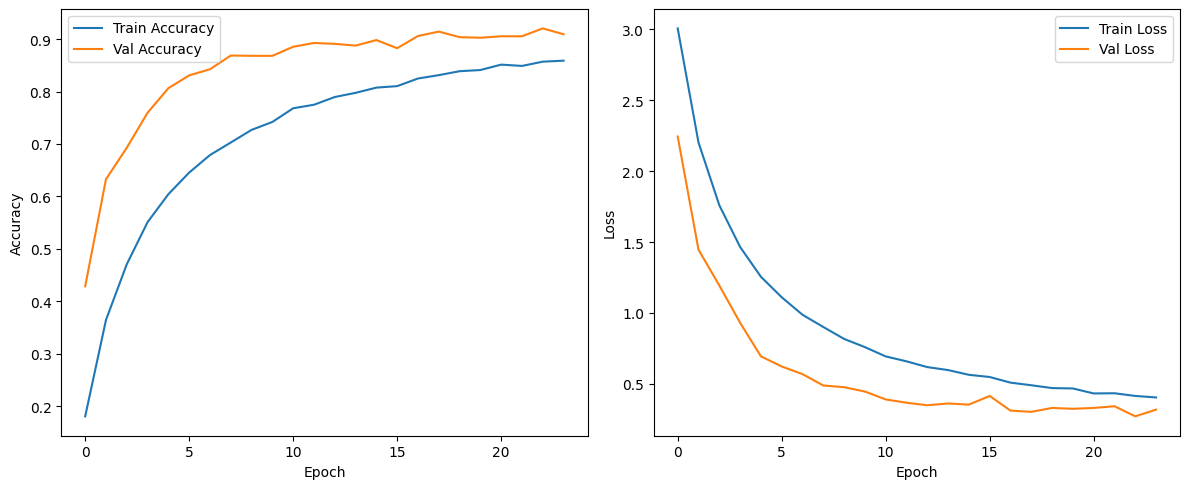

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


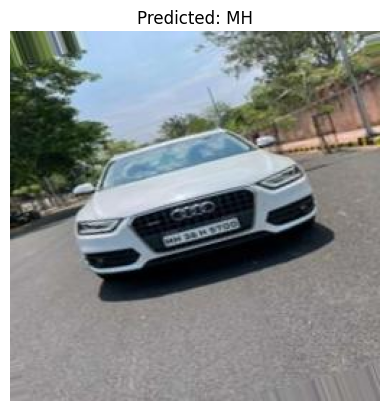

Predicted class: MH


In [20]:
model = load_model("final_model.h5")

def preprocess_image(img_path):
    img = Image.open(img_path).convert("L")
    img = img.resize((128, 128))
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    img_array = np.expand_dims(img_array, axis=-1)
    return img_array


img_path = '/content/downloaded_2.jpg'
img = preprocess_image(img_path)

prediction = model.predict(img)

predicted_class_index = np.argmax(prediction, axis=1)
class_labels = list(train_data.class_indices.keys())
predicted_class = class_labels[predicted_class_index[0]]


img_show = Image.open(img_path)
plt.imshow(img_show)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()

print(f"Predicted class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


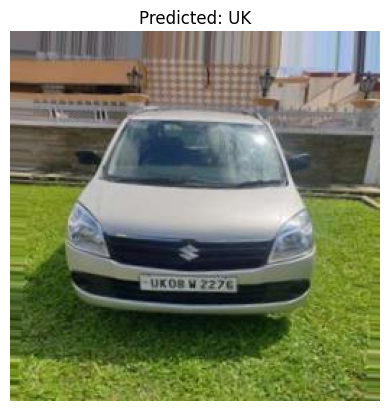

Predicted class: UK


In [18]:
model = load_model("final_model.h5")

def preprocess_image(img_path):
    img = Image.open(img_path).convert("L")
    img = img.resize((128, 128))
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    img_array = np.expand_dims(img_array, axis=-1)
    return img_array


img_path = '/content/downloaded_3.jpg'
img = preprocess_image(img_path)

prediction = model.predict(img)

predicted_class_index = np.argmax(prediction, axis=1)
class_labels = list(train_data.class_indices.keys())
predicted_class = class_labels[predicted_class_index[0]]


img_show = Image.open(img_path)
plt.imshow(img_show)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()

print(f"Predicted class: {predicted_class}")
